In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

data_path = '/Users/admin/Downloads/bike+sharing+dataset/day.csv'

data = pd.read_csv(data_path)

columns_to_drop = ['instant', 'dteday', 'casual', 'registered']
data.drop(columns=columns_to_drop, inplace=True)

X = data.drop(columns='cnt').values
y = data[['cnt']].values

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)


In [13]:
def create_sequences(X, y, window=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 7 
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window=sequence_length)

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)


In [14]:
def custom_r2(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1.0 - ss_res / (ss_tot + K.epsilon())


In [15]:
def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true)**2)

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / (ss_tot + 1e-8)


In [ ]:
class RNN:
    def __init__(self, input_size, hidden_size, output_size, lr=0.001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = lr
        
        def rand_mat(r, c): return np.random.randn(r, c) * 0.01
        
        self.Wh = rand_mat(hidden_size, input_size)
        self.Uh = rand_mat(hidden_size, hidden_size)
        self.bh = np.zeros((hidden_size, 1))
        
        self.Why = rand_mat(output_size, hidden_size)
        self.by = np.zeros((output_size, 1))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def forward(self, inputs):
        self.inputs = inputs
        self.hs = {}
        self.hs[-1] = np.zeros((self.hidden_size, 1))
        
        for t in range(len(inputs)):
            x = inputs[t].reshape(-1,1)
            h_prev = self.hs[t-1]
            h = self.tanh(self.Wh @ x + self.Uh @ h_prev + self.bh)
            self.hs[t] = h
        
        y = self.Why @ self.hs[len(inputs)-1] + self.by
        self.last_y = y
        return y.flatten()
    
    def backward(self, dy):
        dWhy = dy.reshape(-1,1) @ self.hs[len(self.inputs)-1].T
        dby = dy.reshape(-1,1)
        
        dh_next = self.Why.T @ dy.reshape(-1,1)
        
        dWh = np.zeros_like(self.Wh)
        dUh = np.zeros_like(self.Uh)
        dbh = np.zeros_like(self.bh)
        
        for t in reversed(range(len(self.inputs))):
            x = self.inputs[t].reshape(-1,1)
            h = self.hs[t]
            h_prev = self.hs[t-1]
            dtanh = (1 - h ** 2) * dh_next
            
            dWh += dtanh @ x.T
            dUh += dtanh @ h_prev.T
            dbh += dtanh
            
            dh_next = self.Uh.T @ dtanh
        
        for dparam in [dWh, dUh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)
        
        self.Wh -= self.lr * dWh
        self.Uh -= self.lr * dUh
        self.bh -= self.lr * dbh
        self.Why -= self.lr * dWhy
        self.by -= self.lr * dby

class GRU:
    def __init__(self, input_size, hidden_size, output_size, lr=0.001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = lr
        
        def rand_mat(r, c): return np.random.randn(r, c) * 0.01
        
        # Update gate
        self.Wz = rand_mat(hidden_size, input_size)
        self.Uz = rand_mat(hidden_size, hidden_size)
        self.bz = np.zeros((hidden_size,1))
        # Reset gate
        self.Wr = rand_mat(hidden_size, input_size)
        self.Ur = rand_mat(hidden_size, hidden_size)
        self.br = np.zeros((hidden_size,1))
        # Candidate
        self.Wh = rand_mat(hidden_size, input_size)
        self.Uh = rand_mat(hidden_size, hidden_size)
        self.bh = np.zeros((hidden_size,1))
        # Output
        self.Why = rand_mat(output_size, hidden_size)
        self.by = np.zeros((output_size,1))
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def forward(self, inputs):
        self.inputs = inputs
        self.hs = {}
        self.hs[-1] = np.zeros((self.hidden_size,1))
        self.zs, self.rs, self.hs_tilde = {}, {}, {}
        
        for t in range(len(inputs)):
            x = inputs[t].reshape(-1,1)
            h_prev = self.hs[t-1]
            
            z = self.sigmoid(self.Wz @ x + self.Uz @ h_prev + self.bz)
            r = self.sigmoid(self.Wr @ x + self.Ur @ h_prev + self.br)
            h_tilde = np.tanh(self.Wh @ x + self.Uh @ (r * h_prev) + self.bh)
            h = (1 - z) * h_prev + z * h_tilde
            
            self.zs[t] = z
            self.rs[t] = r
            self.hs_tilde[t] = h_tilde
            self.hs[t] = h
        
        y = self.Why @ self.hs[len(inputs)-1] + self.by
        self.last_y = y
        return y.flatten()
    
    def backward(self, dy):
        dWhy = dy.reshape(-1,1) @ self.hs[len(self.inputs)-1].T
        dby = dy.reshape(-1,1)
        
        dh_next = self.Why.T @ dy.reshape(-1,1)
        
        dWz = np.zeros_like(self.Wz)
        dUz = np.zeros_like(self.Uz)
        dbz = np.zeros_like(self.bz)
        
        dWr = np.zeros_like(self.Wr)
        dUr = np.zeros_like(self.Ur)
        dbr = np.zeros_like(self.br)
        
        dWh = np.zeros_like(self.Wh)
        dUh = np.zeros_like(self.Uh)
        dbh = np.zeros_like(self.bh)
        
        for t in reversed(range(len(self.inputs))):
            x = self.inputs[t].reshape(-1,1)
            z = self.zs[t]
            r = self.rs[t]
            h_tilde = self.hs_tilde[t]
            h = self.hs[t]
            h_prev = self.hs[t-1]
            
            dz = dh_next * (h_tilde - h_prev)
            dz_raw = dz * z * (1 - z)
            
            dh_tilde = dh_next * z
            dh_tilde_raw = (1 - h_tilde ** 2) * dh_tilde
            
            dr = (self.Uh.T @ dh_tilde_raw) * h_prev
            dr_raw = dr * r * (1 - r)
            
            dWz += dz_raw @ x.T
            dUz += dz_raw @ h_prev.T
            dbz += dz_raw
            
            dWr += dr_raw @ x.T
            dUr += dr_raw @ h_prev.T
            dbr += dr_raw
            
            dWh += dh_tilde_raw @ x.T
            dUh += dh_tilde_raw @ (r * h_prev).T
            dbh += dh_tilde_raw
            
            dh_prev = dh_next * (1 - z) + self.Uz.T @ dz_raw + self.Ur.T @ dr_raw + r * (self.Uh.T @ dh_tilde_raw)
            
            dh_next = dh_prev
        
        for dparam in [dWz,dUz,dWr,dUr,dWh,dUh,dby,dbz,dbr,dbh,dby,dWhy]:
            np.clip(dparam, -5, 5, out=dparam)
        
        self.Wz -= self.lr * dWz
        self.Uz -= self.lr * dUz
        self.bz -= self.lr * dbz
        
        self.Wr -= self.lr * dWr
        self.Ur -= self.lr * dUr
        self.br -= self.lr * dbr
        
        self.Wh -= self.lr * dWh
        self.Uh -= self.lr * dUh
        self.bh -= self.lr * dbh
        
        self.Why -= self.lr * dWhy
        self.by -= self.lr * dby

class LSTM:
    def __init__(self, input_size, hidden_size, output_size, lr=0.001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = lr
        
        def rand_mat(r,c): return np.random.randn(r,c)*0.01
        
        # Forget gate
        self.Wf = rand_mat(hidden_size, input_size)
        self.Uf = rand_mat(hidden_size, hidden_size)
        self.bf = np.zeros((hidden_size,1))
        # Input gate
        self.Wi = rand_mat(hidden_size, input_size)
        self.Ui = rand_mat(hidden_size, hidden_size)
        self.bi = np.zeros((hidden_size,1))
        # Candidate
        self.Wc = rand_mat(hidden_size, input_size)
        self.Uc = rand_mat(hidden_size, hidden_size)
        self.bc = np.zeros((hidden_size,1))
        # Output gate
        self.Wo = rand_mat(hidden_size, input_size)
        self.Uo = rand_mat(hidden_size, hidden_size)
        self.bo = np.zeros((hidden_size,1))
        # Output layer
        self.Why = rand_mat(output_size, hidden_size)
        self.by = np.zeros((output_size,1))
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def forward(self, inputs):
        self.inputs = inputs
        self.hs = {}
        self.cs = {}
        self.fs = {}
        self.is_ = {}
        self.cs_tilde = {}
        self.os = {}
        
        self.hs[-1] = np.zeros((self.hidden_size,1))
        self.cs[-1] = np.zeros((self.hidden_size,1))
        
        for t in range(len(inputs)):
            x = inputs[t].reshape(-1,1)
            h_prev = self.hs[t-1]
            c_prev = self.cs[t-1]
            
            f = self.sigmoid(self.Wf @ x + self.Uf @ h_prev + self.bf)
            i = self.sigmoid(self.Wi @ x + self.Ui @ h_prev + self.bi)
            c_tilde = np.tanh(self.Wc @ x + self.Uc @ h_prev + self.bc)
            c = f * c_prev + i * c_tilde
            o = self.sigmoid(self.Wo @ x + self.Uo @ h_prev + self.bo)
            h = o * np.tanh(c)
            
            self.fs[t] = f
            self.is_[t] = i
            self.cs_tilde[t] = c_tilde
            self.cs[t] = c
            self.os[t] = o
            self.hs[t] = h
        
        y = self.Why @ self.hs[len(inputs)-1] + self.by
        self.last_y = y
        return y.flatten()
    
    def backward(self, dy):
        dWhy = dy.reshape(-1,1) @ self.hs[len(self.inputs)-1].T
        dby = dy.reshape(-1,1)
        
        dh_next = self.Why.T @ dy.reshape(-1,1)
        dc_next = np.zeros_like(dh_next)
        
        dWf = np.zeros_like(self.Wf)
        dWi = np.zeros_like(self.Wi)
        dWc = np.zeros_like(self.Wc)
        dWo = np.zeros_like(self.Wo)
        
        dUf = np.zeros_like(self.Uf)
        dUi = np.zeros_like(self.Ui)
        dUc = np.zeros_like(self.Uc)
        dUo = np.zeros_like(self.Uo)
        
        dbf = np.zeros_like(self.bf)
        dbi = np.zeros_like(self.bi)
        dbc = np.zeros_like(self.bc)
        dbo = np.zeros_like(self.bo)
        
        for t in reversed(range(len(self.inputs))):
            x = self.inputs[t].reshape(-1,1)
            f = self.fs[t]
            i = self.is_[t]
            c_tilde = self.cs_tilde[t]
            c = self.cs[t]
            o = self.os[t]
            h = self.hs[t]
            h_prev = self.hs[t-1]
            c_prev = self.cs[t-1]
            
            do = dh_next * np.tanh(c)
            do_raw = do * o * (1 - o)
            
            dc = dh_next * o * (1 - np.tanh(c)**2) + dc_next
            dc_tilde = dc * i
            dc_tilde_raw = dc_tilde * (1 - c_tilde**2)
            
            di = dc * c_tilde
            di_raw = di * i * (1 - i)
            
            df = dc * c_prev
            df_raw = df * f * (1 - f)
            
            dWf += df_raw @ x.T
            dUf += df_raw @ h_prev.T
            dbf += df_raw
            
            dWi += di_raw @ x.T
            dUi += di_raw @ h_prev.T
            dbi += di_raw
            
            dWc += dc_tilde_raw @ x.T
            dUc += dc_tilde_raw @ h_prev.T
            dbc += dc_tilde_raw
            
            dWo += do_raw @ x.T
            dUo += do_raw @ h_prev.T
            dbo += do_raw
            
            dh_prev = (self.Uf.T @ df_raw + self.Ui.T @ di_raw + self.Uc.T @ dc_tilde_raw + self.Uo.T @ do_raw)
            dc_next = f * dc
            dh_next = dh_prev
        
        for dparam in [dWf,dWi,dWc,dWo,dUf,dUi,dUc,dUo,dbf,dbi,dbc,dbo,dby,dWhy]:
            np.clip(dparam, -5, 5, out=dparam)
        
        self.Wf -= self.lr * dWf
        self.Uf -= self.lr * dUf
        self.bf -= self.lr * dbf
        
        self.Wi -= self.lr * dWi
        self.Ui -= self.lr * dUi
        self.bi -= self.lr * dbi
        
        self.Wc -= self.lr * dWc
        self.Uc -= self.lr * dUc
        self.bc -= self.lr * dbc
        
        self.Wo -= self.lr * dWo
        self.Uo -= self.lr * dUo
        self.bo -= self.lr * dbo
        
        self.Why -= self.lr * dWhy
        self.by -= self.lr * dby


In [17]:
def train_manual_model(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    train_losses = []
    val_losses = []
    val_r2s = []
    
    n = len(X_train)
    
    for epoch in range(epochs):
        perm = np.random.permutation(n)
        train_loss_epoch = 0
        
        for i in range(0, n, batch_size):
            batch_idx = perm[i:i+batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]
            
            batch_loss = 0
            
            for x_seq, y_true in zip(X_batch, y_batch):
                y_pred = model.forward(x_seq)
                loss = mse_loss(y_pred, y_true)
                batch_loss += loss
                
                dy = 2 * (y_pred - y_true) / len(y_true)  # градиент MSE
                model.backward(dy)
            
            train_loss_epoch += batch_loss / len(X_batch)
        
        train_losses.append(train_loss_epoch / (n // batch_size))
        
        # Валидация
        val_preds = []
        for x_seq in X_val:
            y_pred = model.forward(x_seq)
            val_preds.append(y_pred)
        val_preds = np.array(val_preds)
        
        val_loss = mse_loss(val_preds, y_val)
        val_r2 = r2_score(y_val, val_preds)
        
        val_losses.append(val_loss)
        val_r2s.append(val_r2)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_loss:.4f} - Val R²: {val_r2:.4f}")
    
    return train_losses, val_losses, val_r2s


Обучение SimpleRNN
Epoch 1/50 - Train Loss: 0.0382 - Val Loss: 0.1118 - Val R²: -5.6439
Epoch 2/50 - Train Loss: 0.0284 - Val Loss: 0.1331 - Val R²: -6.9089
Epoch 3/50 - Train Loss: 0.0273 - Val Loss: 0.0906 - Val R²: -4.3838
Epoch 4/50 - Train Loss: 0.0250 - Val Loss: 0.0877 - Val R²: -4.2104
Epoch 5/50 - Train Loss: 0.0219 - Val Loss: 0.0584 - Val R²: -2.4706
Epoch 6/50 - Train Loss: 0.0183 - Val Loss: 0.0563 - Val R²: -2.3441
Epoch 7/50 - Train Loss: 0.0149 - Val Loss: 0.0331 - Val R²: -0.9682
Epoch 8/50 - Train Loss: 0.0133 - Val Loss: 0.0221 - Val R²: -0.3130
Epoch 9/50 - Train Loss: 0.0123 - Val Loss: 0.0212 - Val R²: -0.2616
Epoch 10/50 - Train Loss: 0.0120 - Val Loss: 0.0219 - Val R²: -0.3000
Epoch 11/50 - Train Loss: 0.0122 - Val Loss: 0.0210 - Val R²: -0.2501
Epoch 12/50 - Train Loss: 0.0118 - Val Loss: 0.0227 - Val R²: -0.3465
Epoch 13/50 - Train Loss: 0.0120 - Val Loss: 0.0231 - Val R²: -0.3698
Epoch 14/50 - Train Loss: 0.0117 - Val Loss: 0.0203 - Val R²: -0.2063
Epoch 15/5

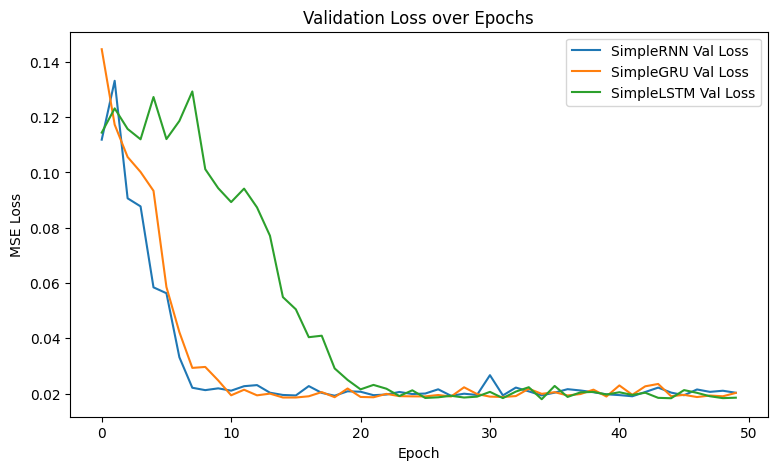

In [ ]:
input_size = X_train.shape[2]
hidden_size = 32
output_size = 1
learning_rate = 0.001
num_epochs = 50
batch_size = 32

val_split = 0.2
split_idx = int(len(X_train)*(1-val_split))
X_train_main, X_val = X_train[:split_idx], X_train[split_idx:]
y_train_main, y_val = y_train[:split_idx], y_train[split_idx:]

val_losses = {}
val_r2_scores = {}

# SimpleRNN
rnn_model = SimpleRNN(input_size, hidden_size, output_size, learning_rate)
print("Обучение SimpleRNN")
rnn_train_loss, rnn_val_loss, rnn_val_r2 = train_manual_model(rnn_model, X_train_main, y_train_main, X_val, y_val, num_epochs, batch_size)
val_losses['SimpleRNN'] = rnn_val_loss
val_r2_scores['SimpleRNN'] = rnn_val_r2

# SimpleGRU
gru_model = SimpleGRU(input_size, hidden_size, output_size, learning_rate)
print("\nОбучение SimpleGRU")
gru_train_loss, gru_val_loss, gru_val_r2 = train_manual_model(gru_model, X_train_main, y_train_main, X_val, y_val, num_epochs, batch_size)
val_losses['SimpleGRU'] = gru_val_loss
val_r2_scores['SimpleGRU'] = gru_val_r2

# SimpleLSTM
lstm_model = SimpleLSTM(input_size, hidden_size, output_size, learning_rate)
print("\nОбучение SimpleLSTM")
lstm_train_loss, lstm_val_loss, lstm_val_r2 = train_manual_model(lstm_model, X_train_main, y_train_main, X_val, y_val, num_epochs, batch_size)
val_losses['SimpleLSTM'] = lstm_val_loss
val_r2_scores['SimpleLSTM'] = lstm_val_r2

# Визуализация результатов
plt.figure(figsize=(9,5))
for key in val_losses:
    plt.plot(val_losses[key], label=f'{key} Val Loss')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()



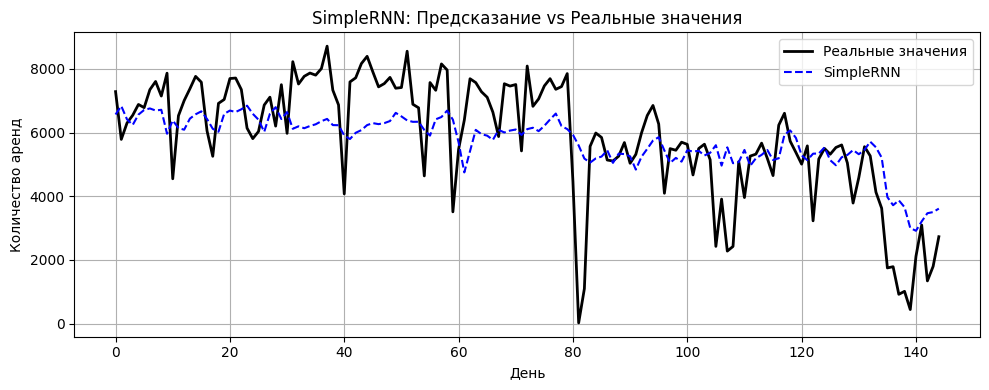

In [19]:
def manual_model_predict(model, X):
    preds = []
    for x_seq in X:
        y_pred = model.forward(x_seq)
        preds.append(y_pred)
    return np.array(preds)

y_pred_rnn = y_scaler.inverse_transform(manual_model_predict(rnn_model, X_test))
y_pred_gru = y_scaler.inverse_transform(manual_model_predict(gru_model, X_test))
y_pred_lstm = y_scaler.inverse_transform(manual_model_predict(lstm_model, X_test))
y_test_real = y_scaler.inverse_transform(y_test)


plt.figure(figsize=(10, 4))
plt.plot(y_test_real, label='Реальные значения', color='black', linewidth=2)
plt.plot(y_pred_rnn, label='SimpleRNN', linestyle='--', color='blue')
plt.title('SimpleRNN: Предсказание vs Реальные значения')
plt.xlabel('День')
plt.ylabel('Количество аренд')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

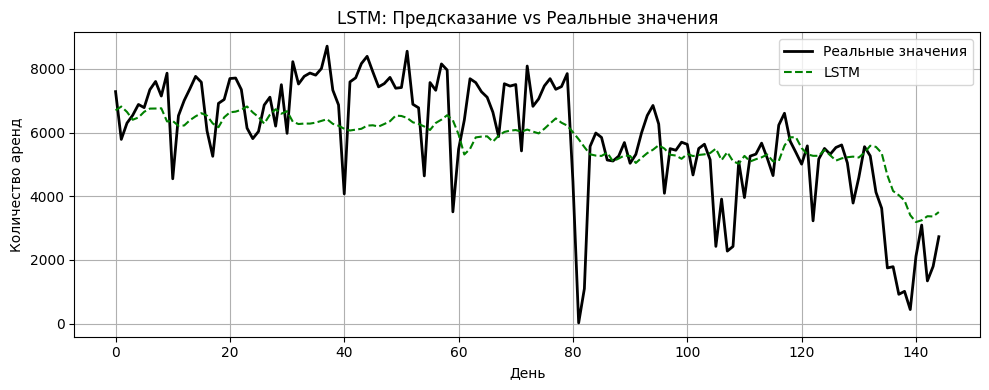

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_real, label='Реальные значения', color='black', linewidth=2)
plt.plot(y_pred_lstm, label='LSTM', linestyle='--', color='green')
plt.title('LSTM: Предсказание vs Реальные значения')
plt.xlabel('День')
plt.ylabel('Количество аренд')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

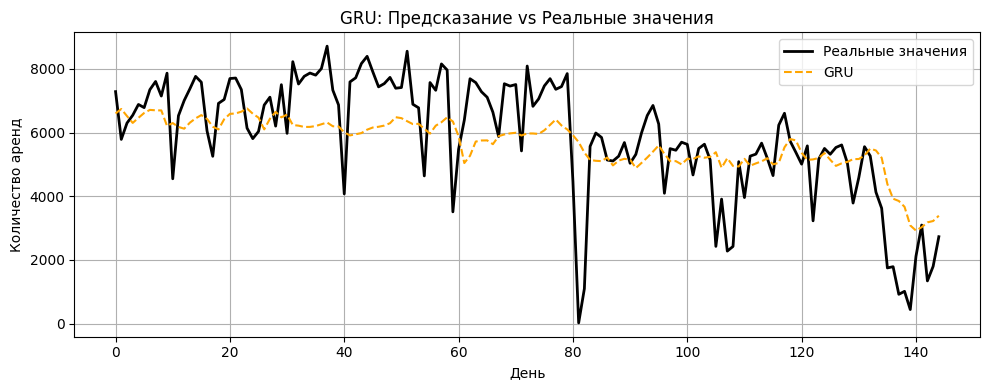

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_real, label='Реальные значения', color='black', linewidth=2)
plt.plot(y_pred_gru, label='GRU', linestyle='--', color='orange')
plt.title('GRU: Предсказание vs Реальные значения')
plt.xlabel('День')
plt.ylabel('Количество аренд')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()